## Course: TM10007 - Machine learning
Editors: Lishia Vergeer, Amy Roos, Maaike Pruijt, Hilde Roording.

Description: The aim of this code is to predict the tumor grade of glioma’s(high or low) before surgery, 
based on features extracted from a combination of four MRI images: 
T2-weighted, T2-weighted FLAIR and T1-weighted before and after injection of contrast agent.

#### Import packages

In [59]:
# General packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #logische naam?

# Import code
from brats.load_data import load_data

# Performance 
from sklearn.model_selection import train_test_split
from sklearn import decomposition

# gridsearch
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# scaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler #nog even kiezen?

#Machine learning classifiers
from sklearn.decomposition import PCA #niet accessed?
from sklearn import metrics  # weg?
from sklearn.metrics import roc_auc_score #nog niet gebruikt
from sklearn.feature_selection import chi2
from sklearn.model_selection import cross_validate
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold




#### Load data

In [43]:
data_brats = load_data()

# Convert to dataframe
X = pd.DataFrame(data_brats)

# Print data 
print(f'The number of samples in data_brats: {len(X.index)}')
print(f'The number of columns in data_brats: {len(X.columns)}')


The number of samples in data_brats: 167
The number of columns in data_brats: 725


#### Split data in X and y
Split in X (data) and y (label)

In [44]:
# split column label from dataset X
y = X.pop('label')

# replace 'GBM' and 'LGG' with 1 and 0 respectively
y = y.replace(['GBM'], 1)
y = y.replace(['LGG'], 0)



#### Split data in train and test set
This function creates a panda dataframe and splits the data into test and train components.
This is done with test_size variable and the function train_test_split from the sklearn module.
Returns a train set with the data of 80% and a test set of 20% of the subjects.



In [45]:
# Split data in train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)  


#### Divergent values to NaN

In [46]:

# infinity to NaN
X_train[X_train==np.inf]=np.nan
X_test[X_test==np.inf]=np.nan

# non-numeric features to NaN
X_train = X_train.replace(['#DIV/0!'], np.nan)
X_train = X_train.apply(pd.to_numeric, errors='coerce')

X_test  = X_test.replace(['#DIV/0!'], np.nan)
X_test = X_test.apply(pd.to_numeric, errors='coerce')

#### Visualising outliers

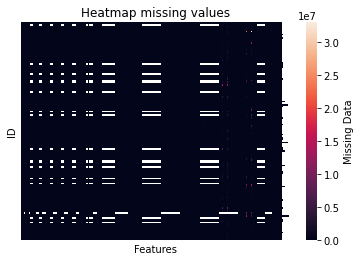

In [47]:
sns.heatmap(X_train, yticklabels=False, xticklabels=False, cbar_kws={'label': 'Missing Data'})
plt.title('Heatmap missing values')
plt.xlabel('Features')
plt.ylabel('ID')
plt.savefig("visualizing_missing_data_with_heatmap.png", dpi=100)

#### Outliers to NaN



In [48]:
for column in X_train:
    # Removing outliers
    q1 = X_train[column].quantile(0.25)
    q3 = X_train[column].quantile(0.75)
    iqr = q3-q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    #print(column)

    # Information outliers
    outliers = [x for x in X_train[column] if x < lower or x > upper]
    outliers_removed = [x for x in X_train[column] if x >= lower and x <= upper]
    #print('Identified outliers: %d' % len(outliers))
    #print('Non-outlier observations: %d' % len(outliers_removed))


    X_train[column].loc[X_train[column] > upper] = np.nan
    X_train[column].loc[X_train[column] < lower] = np.nan

C:\Users\amymy\miniconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


#### Visualising missing data after removing outliers

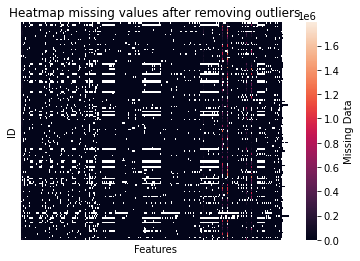

In [49]:
sns.heatmap(X_train, yticklabels=False, xticklabels=False, cbar_kws={'label': 'Missing Data'})
plt.title('Heatmap missing values after removing outliers')
plt.xlabel('Features')
plt.ylabel('ID')
plt.savefig("visualizing_missing_data_with_heatmap_outliers.png", dpi=100)


#### Drop columns

In [50]:
# If the total number of NaN observations in a column are greater than 40%, delete the entire column.
perc = 40.0
min_count = int(((100-perc)/100)*X_train.shape[0] + 1)
X_train_drop = X_train.dropna(axis=1, thresh=min_count)
X_labels = X_train_drop.keys()

X_test_drop = X_test[X_labels]

#### Fill the NaN observations.


In [51]:
data_fill_train = X_train_drop.fillna(X_train_drop.mean()) 
data_fill_test = X_test_drop.fillna(X_test_drop.mean()) 

#### Scale features

In [52]:
# Scaler
scaler = StandardScaler()
scaler.fit(data_fill_train)
X_train_scaled = scaler.transform(data_fill_train)
X_test_scaled = scaler.transform(data_fill_test)

#### Transform features

In [53]:
# Perform a PCA
pca = decomposition.PCA(n_components=5)
pca.fit(X_train_scaled) 
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


#### Test Classifiers

In [54]:
"""
#Confusion matrix, Accuracy, sensitivity and specificity
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
classifiers = (KNeighborsClassifier(), RandomForestClassifier(), SVC(kernel="rbf", C=0.025, probability=True), NuSVC(probability=True))

for cls in classifiers:
    model = cls
    model.fit(X_train_pca, y_train)

    preds = model.predict(X_train_pca)

    metrics.plot_confusion_matrix(model, X_train_pca, y_train)
    display_labels =['Negative', 'Positive']


    confusion = metrics.confusion_matrix(y_train, preds)
    accuracy = metrics.accuracy_score(y_train, preds)
    sensitivity = metrics.recall_score(y_train, preds, pos_label='GBM')
    specificity = metrics.recall_score(y_train, preds, pos_label='LGG')

    #table = {'classifier': cls, 'accuracy': accuracy, 'Sensitivity', sensitivity, 'Specificity': specificity}
    print(f'For classifier: {cls}, Accuracy: {accuracy}, Sensitivity: {sensitivity}, Specificity{specificity}')

"""

'\n#Confusion matrix, Accuracy, sensitivity and specificity\nfrom sklearn.metrics import confusion_matrix\nimport matplotlib.pyplot as plt\nfrom sklearn.datasets import make_classification\nfrom sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.svm import SVC\nclassifiers = (KNeighborsClassifier(), RandomForestClassifier(), SVC(kernel="rbf", C=0.025, probability=True), NuSVC(probability=True))\n\nfor cls in classifiers:\n    model = cls\n    model.fit(X_train_pca, y_train)\n\n    preds = model.predict(X_train_pca)\n\n    metrics.plot_confusion_matrix(model, X_train_pca, y_train)\n    display_labels =[\'Negative\', \'Positive\']\n\n\n    confusion = metrics.confusion_matrix(y_train, preds)\n    accuracy = metrics.accuracy_score(y_train, preds)\n    sensitivity = metrics.recall_score(y_train, preds, pos_label=\'GBM\')\n    specificity = metrics.recall_score(y_train, preds, pos_label=\'LGG\')\n\n    #table =

#### Cross validation

In [55]:
# Create a cross-validation object
cv = KFold(n_splits=5, shuffle= True, random_state = 1)

X = X_train_pca

y = y_train.values
y = y.tolist()

classifiers = (KNeighborsClassifier(), RandomForestClassifier(), SVC())
scores = ['accuracy', 'recall', 'roc_auc']

score_list = []
for cls in classifiers:
    score_dict = {'Classifier':[cls]}
    score_list.append(score_dict)
    for score in scores:
        list_scores = cross_val_score(cls, X, y, scoring = score , cv=cv)
        mean = np.mean(list_scores)
        score_dict ={score: [mean]}
        score_list.append(score_dict)
        print(f'The classifier{cls} has mean {score} of:', mean)
        
dict1 = score_list[0] | score_list[1] | score_list[2] | score_list[3]
dict2 = score_list[4] | score_list[5] | score_list[6] | score_list[7]
dict3 = score_list[8] | score_list[9] | score_list[10] | score_list[11]

score_frame1 = pd.DataFrame(dict1)
score_frame2 = pd.DataFrame(dict2)
score_frame3 = pd.DataFrame(dict3)
frames = [score_frame1, score_frame2, score_frame3]
score_frame = pd.concat(frames)
print(score_frame)


[1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]
The classifierKNeighborsClassifier() has mean accuracy of: 0.8113960113960113
The classifierKNeighborsClassifier() has mean recall of: 0.8558730158730159
The classifierKNeighborsClassifier() has mean roc_auc of: 0.8821097421097421
The classifierRandomForestClassifier() has mean accuracy of: 0.7891737891737891
The classifierRandomForestClassifier() has mean recall of: 0.8382539682539683
The classifierRandomForestClassifier() has mean roc_auc of: 0.8642878109544776
The classifierSVC() has mean accuracy of: 0.8492877492877493
The classifierSVC() has mean recall of: 0.9025396825396825
The classifi

#### Random forest model with hyperparameters 
First define some hyperparameters 


In [56]:
# Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 20)]
# Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# Maximum number of levels in tree 
# max_depth = [2, 4]
# Minimum number of samples required to split a node
# min_sample_split = [2, 3]
# Minimum number of samples required at each leaf node
#min_sample_leaf = [1, 2]
# Method of selecting samples for training each tree
#bootstrap = [True, False]

# Create a dictionary of the hyperparameters above (create a parameter grid)

# param_grid = {
#     'n_estimators': n_estimators, 
#     'max_features': max_features, 
#     'max_depth':max_depth, 
#     'min_sample_split': min_sample_split, 
#     'min_sample_leaf':min_sample_leaf, 
#     'bootstrap': bootstrap }
# print(param_grid)

# Create an insance of the classifier
# rf_model = RandomForestClassifier()

Doing a random gridsearch 

In [57]:
# Doing a random grid search 
# A randomised grid search will perform worse than a gridsearch but it is faster 
# rf_random_grid = RandomizedSearchCV(estimator = rf_model, param_distributions = param_grid, cv = 10, verbose = 2, n_jobs = 4)
# rf_random_grid.fit(X_train_pca, y_train)
# rf_random_grid.best_params_

# results = pd.DataFrame(rf_random_grid.cv_results_)
# print(results)
#print (f' Train Accuracy: {rf_grid.score(X_train_pca, y_train):.3f}')
#print (f' Test Accuracy: {rf_grid.score(X_test_pca, y_test):.3f}')

# print (f' Test Accuracy: {rf_random_grid.score(X_train_pca, y_train):.3f}')
# print (f' Test Accuracy: {rf_random_grid.score(X_test_pca, y_test):.3f}')



#### Support Vector Machine
Hyperparameters


In [58]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma' : [1, 0.1, 0.01, 0.001],
    'kernel' : ['linear']
}

svm_model = SVC(gamma='auto')

rf_grid = RandomizedSearchCV(estimator = svm_model, param_distributions = param_grid, cv = 3, verbose = 2, n_jobs =4)
rf_grid.fit(X_train_pca, y_train)

best_param = rf_grid.best_params_
best_estimator = rf_grid.best_estimator_

print(f'The best parameters are : {best_param}')
print(f'The best estimators are : {best_estimator}')
print(f'Test accuracy train set is:{rf_grid.score(X_train_pca, y_train):.3f}')
print (f'Test accuracy test set is: {rf_grid.score(X_test_pca, y_test):.3f}')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
The best parameters are : {'kernel': 'linear', 'gamma': 0.001, 'C': 1}
The best estimators are : SVC(C=1, gamma=0.001, kernel='linear')
Test accuracy train set is:0.872
Test accuracy test set is: 0.794
